# 3SAT -> Node-Disjoint Paths


To Do

If Sat Output

Result +

1.) the Node Disjoint Paths of the Graph

2.) The variable assignements

If Unsat Output

Result + 

3.) All attempted Paths

4.) All variable assignements

Other:

5.) File with adjaceny list of the corresponding graph

6.) A visualization of the graph that is formed

Maybe:

7.) interactive program for inputting file name and location rather than hardcoding file path

Input: csv file path
Output: file paths for output files
Then Show a visual of the graph.


In [83]:
import csv
import networkx as nx
from itertools import product
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Function to read csv and store variables and clauses
def read_sat_csv(file_path):
    variables = set()
    clauses = []
    
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        
        for row in reader:
            clause = [int(x) for x in row]  # Convert each value to an integer
            clauses.append(clause)
            
            # Add absolute values of variables to the set
            for var in clause:
                variables.add(abs(var))
    
    return variables, clauses


def transformation(variables, clauses):
    
    # Define Graph     
    G = nx.DiGraph()
    
    source_sink_pairs = {} 
    variable_nodes = {}
    all_ss_pairs = []
    # Sinks and sources for each variable     
    for variable in variables:
        s_x = f"s_{variable}"
        t_x = f"t_{variable}"
        source_sink_pairs[variable] = (s_x, t_x)
        all_ss_pairs.append((s_x,t_x))
        G.add_node(s_x)
        G.add_node(t_x)
    
    # Clause connections     
    for i in range(len(clauses)):
        c = f"c_{i+1}"
        d = f"d_{i+1}"
        
        G.add_node(c)
        G.add_node(d)
        all_ss_pairs.append((c,d))
        
        for literal in clauses[i]:
            var = abs(literal)
            
            t_x = f"T_c{i+1}x{var}"
            f_x = f"F_c{i+1}x{var}"
            variable_nodes[(i+1,var)] = (t_x,f_x)
            
            # Not x_i
            if(literal < 0):
                G.add_edge(c, t_x)
                G.add_edge(t_x, d)
            else:
                G.add_edge(c, f_x)
                G.add_edge(f_x, d)

    print(variable_nodes) 
    print(source_sink_pairs)
    print(all_ss_pairs)
                
    for var in variables:        
        s_x, t_x = source_sink_pairs[var]
        temp1, temp2 = s_x, s_x
        for i in range(len(clauses)):
            if ((i+1, var)) in variable_nodes:
                T, F = variable_nodes[(i+1, var)]
                G.add_edge(temp1, T)
                G.add_edge(temp2, F)
                temp1 = T
                temp2 = F
        G.add_edge(temp1, t_x)
        G.add_edge(temp2, t_x)
    
    return G, all_ss_pairs


In [84]:
variables = [1,2,3,4]
clauses = [[1,-2,3],[1,2,-4]]

G,  pairs = transformation(variables, clauses)

{(1, 1): ('T_c1x1', 'F_c1x1'), (1, 2): ('T_c1x2', 'F_c1x2'), (1, 3): ('T_c1x3', 'F_c1x3'), (2, 1): ('T_c2x1', 'F_c2x1'), (2, 2): ('T_c2x2', 'F_c2x2'), (2, 4): ('T_c2x4', 'F_c2x4')}
{1: ('s_1', 't_1'), 2: ('s_2', 't_2'), 3: ('s_3', 't_3'), 4: ('s_4', 't_4')}
[('s_1', 't_1'), ('s_2', 't_2'), ('s_3', 't_3'), ('s_4', 't_4'), ('c_1', 'd_1'), ('c_2', 'd_2')]


In [85]:
# Helper function to find all paths from source to target in a NetworkX graph
def find_all_paths(G, source, target):
    return list(nx.all_simple_paths(G, source, target))

# Recursive backtracking function to find node-disjoint paths
# selects a set of node-disjoint paths for multiple source-sink pairs in a graph. It systematically tries different 
# combinations of paths using recursion to ensure the selected paths do not overlap in their intermediate nodes.
# Doing so reduces redundant checks making the amount of operation less
def backtrack(all_paths, current_index, visited_nodes, selected_paths, tried_combinations):
    if current_index == len(all_paths):
        return True  # All pairs have been assigned node-disjoint paths

    valid = False  # Tracks if any valid path configuration is found at this level

    for path in all_paths[current_index]:
        # Check if the path is node-disjoint with already selected paths
        path_nodes = set(path[1:-1])  # Exclude source and sink nodes
        if not path_nodes & visited_nodes:  # No overlap with visited nodes
            # Mark nodes as visited and continue backtracking
            visited_nodes.update(path_nodes)
            selected_paths.append(path)
            
            # Continue to the next level
            if backtrack(all_paths, current_index + 1, visited_nodes, selected_paths, tried_combinations):
                valid = True
                break  # No need to explore further if a valid solution is found
            
            # Backtrack: remove the nodes from visited set and path from selection
            visited_nodes.difference_update(path_nodes)
            selected_paths.pop()
    
    if not valid and current_index == len(selected_paths):  # Only record failed combinations when at the last level
        tried_combinations.append(list(selected_paths))
    
    return valid

# Main function to find node-disjoint paths for each source-sink pair in a NetworkX graph
def node_disjoint_paths(G, source_sink_pairs):
    # Generate all paths for each source-sink pair
    all_paths = []
    for source, sink in source_sink_pairs:
        paths = find_all_paths(G, source, sink)
        if not paths:
            return False, [], []  # No path exists for a source-sink pair
        all_paths.append(paths)
    
    # Use backtracking to check for a valid combination of node-disjoint paths
    visited_nodes = set()
    selected_paths = []
    tried_combinations = []
    
    found = backtrack(all_paths, 0, visited_nodes, selected_paths, tried_combinations)
    
    if found:
        return True, selected_paths, tried_combinations
    else:
        return False, [], tried_combinations

In [86]:
node_disjoint_paths(G, pairs)

(True,
 [['s_1', 'T_c1x1', 'T_c2x1', 't_1'],
  ['s_2', 'T_c1x2', 'T_c2x2', 't_2'],
  ['s_3', 'T_c1x3', 't_3'],
  ['s_4', 'T_c2x4', 't_4'],
  ['c_1', 'F_c1x1', 'd_1'],
  ['c_2', 'F_c2x1', 'd_2']],
 [])

In [93]:
def handler(file_path):
    variables , clauses = read_sat_csv(file_path)
    
    G,  pairs = transformation(variables, clauses)

    isSat, sat_path, unsat_paths = node_disjoint_paths(G, pairs)
    
    sat_assignments = generate_assignments(sat_path)
    
    print(f'pairs{G.edges}')
    
    unsat_assignments = []
    
    for unsat_path in unsat_paths:
        unsat_assignments.append(generate_assignments(unsat_path))
#     print(sat_assignments)
#     print(unsat_assignments)
    
    # Use sat_path and unsatPaths to write the variable assignments
    file_name = os.path.basename(file_path)
    write_node_disjoint_paths_to_file(f"{file_name}_results.txt", isSat, sat_path, unsat_paths, sat_assignments, unsat_assignments)

    visualize(G, pairs)
    return 


def write_node_disjoint_paths_to_file(output_file, result, disjoint_paths, tried_combinations, sat_assignments, unsat_assignments):
    try:
        with open(output_file, 'w') as file:
            # Write whether a valid solution was found
            file.write(f"Result: {'Valid solution found' if result else 'No valid solution found'}\n\n")
            
            # Write the valid set of disjoint paths (if found)
            
            if result:
                file.write("Satifiable Variable Assignments:\n")
                file.write(str(sat_assignments))
                
                file.write("Disjoint Paths in Graph:\n")
                for path in disjoint_paths:
                    file.write(f"{path}\n")
            else:
                file.write("Disjoint Paths in Graph:\n")
                file.write("None\n")
            file.write("\n")
            
            # Write all sets of tried combinations
            
            if not result:
                file.write("Tried Variable Assignments:")
                for i, unsat in enumerate(unsat_assignments):
                    file.write(f"\nAssignment {i + 1}:\n")
                    file.write(str(unsat))
                file.write("Tried Combinations:\n")
                for i, combination in enumerate(tried_combinations):
                    file.write(f"Combination {i + 1}:\n")
                    for path in combination:
                        file.write(f"  {path}\n")
                    file.write("\n")
                
                
        
        # Confirm successful file creation
        print(f"File '{output_file}' was successfully created.")
    
    except Exception as e:
        # Print an error message if something goes wrong
        print(f"An error occurred while writing to the file: {e}")

def generate_assignments(paths):
    assignments = {}

    # Process each path
    for path in paths:
#         Get first itme
        sink = path[0]
        if sink[0] == 's':
            variable = sink[2]
            assignment = path[1]
            if assignment[0] == "T":
                assignments[f"x{variable}"] = "T"
            else:
                assignments[f"x{variable}"] = "F"
        
    return assignments

In [156]:
def visualize(G, pairs):
    # Custom positions for the nodes
    pos = {}
    
    clause = 0
    var = 0
    
    for source, sink in pairs:
        if source[0] == 's':
            var =  max(var,int(source[-1]))
        if source[0] == 'c':
            clause =  max(clause,int(source[-1]))
    scale_factor = 3
    
    # Positioning logic
    for node in G.nodes:
        if node.startswith('s'):
            pos[node] = (-1, (scale_factor*int(node[-1])))  # Place 's' nodes on the far left
        elif node.startswith('c'):
            pos[node] = (scale_factor*int(node[-1]), scale_factor*(var+2))  # Place 'c' nodes at the top
        elif node.startswith('F'):
            pos[node] = (scale_factor*int(node[3]), scale_factor*int(node[-1])+1.25)  # Align 'F' nodes horizontally by suffix
        elif node.startswith('T'):
            pos[node] = (scale_factor*int(node[3]), scale_factor*int(node[-1])-1.25)  # Align 'T' nodes horizontally by suffix
        elif node.startswith('t'):
            pos[node] = (scale_factor*(clause+2), scale_factor*int(node[-1]))  # Place 't' sinks to the right of 's' sources
        elif node.startswith('d'):
            pos[node] = (scale_factor*int(node[-1]), 0)  # Place 'd' sinks below 'c' sources

    # Draw the graph
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=1000, font_size=8, font_weight="bold")
    plt.title("Custom Graph Visualization with t and d Sinks", fontsize=14)
    plt.show()

{(1, 3): ('T_c1x3', 'F_c1x3'), (1, 4): ('T_c1x4', 'F_c1x4'), (1, 5): ('T_c1x5', 'F_c1x5'), (2, 1): ('T_c2x1', 'F_c2x1'), (2, 6): ('T_c2x6', 'F_c2x6'), (2, 5): ('T_c2x5', 'F_c2x5'), (3, 4): ('T_c3x4', 'F_c3x4'), (3, 5): ('T_c3x5', 'F_c3x5'), (3, 6): ('T_c3x6', 'F_c3x6'), (4, 2): ('T_c4x2', 'F_c4x2'), (4, 4): ('T_c4x4', 'F_c4x4'), (4, 5): ('T_c4x5', 'F_c4x5')}
{1: ('s_1', 't_1'), 2: ('s_2', 't_2'), 3: ('s_3', 't_3'), 4: ('s_4', 't_4'), 5: ('s_5', 't_5'), 6: ('s_6', 't_6')}
[('s_1', 't_1'), ('s_2', 't_2'), ('s_3', 't_3'), ('s_4', 't_4'), ('s_5', 't_5'), ('s_6', 't_6'), ('c_1', 'd_1'), ('c_2', 'd_2'), ('c_3', 'd_3'), ('c_4', 'd_4')]
pairs[('s_1', 'T_c2x1'), ('s_1', 'F_c2x1'), ('s_2', 'T_c4x2'), ('s_2', 'F_c4x2'), ('s_3', 'T_c1x3'), ('s_3', 'F_c1x3'), ('s_4', 'T_c1x4'), ('s_4', 'F_c1x4'), ('s_5', 'T_c1x5'), ('s_5', 'F_c1x5'), ('s_6', 'T_c2x6'), ('s_6', 'F_c2x6'), ('c_1', 'T_c1x3'), ('c_1', 'F_c1x4'), ('c_1', 'T_c1x5'), ('T_c1x3', 'd_1'), ('T_c1x3', 't_3'), ('F_c1x4', 'd_1'), ('F_c1x4', 'F_c

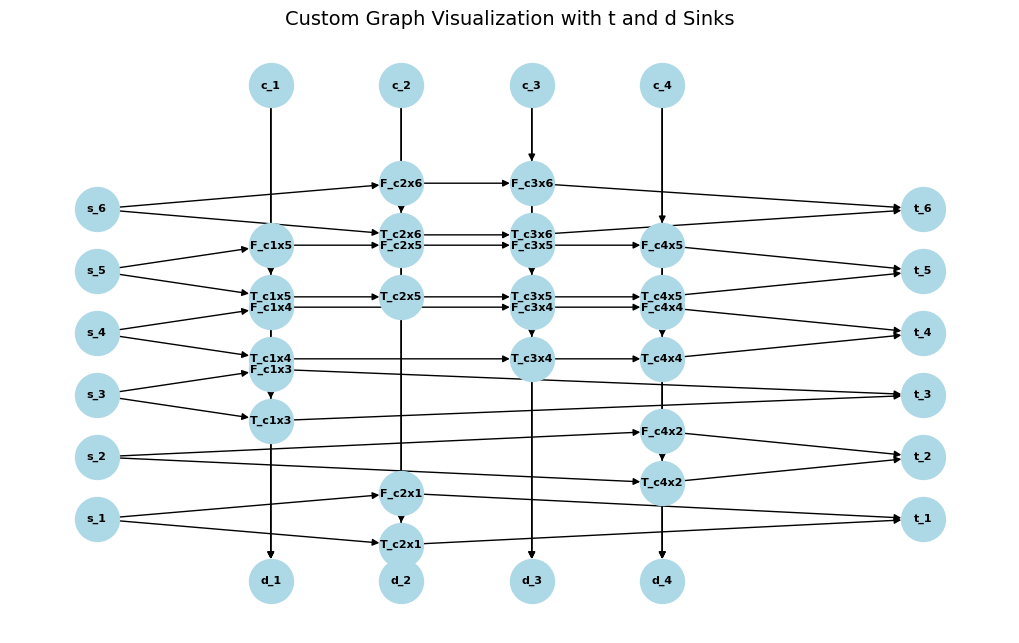

In [157]:
handler('test1.csv')

In [98]:
handler('test2.csv')

{(1, 1): ('T_c1x1', 'F_c1x1'), (1, 2): ('T_c1x2', 'F_c1x2'), (1, 3): ('T_c1x3', 'F_c1x3'), (2, 1): ('T_c2x1', 'F_c2x1'), (2, 2): ('T_c2x2', 'F_c2x2'), (2, 3): ('T_c2x3', 'F_c2x3'), (3, 1): ('T_c3x1', 'F_c3x1'), (3, 2): ('T_c3x2', 'F_c3x2'), (3, 3): ('T_c3x3', 'F_c3x3'), (4, 1): ('T_c4x1', 'F_c4x1'), (4, 2): ('T_c4x2', 'F_c4x2'), (4, 3): ('T_c4x3', 'F_c4x3'), (5, 1): ('T_c5x1', 'F_c5x1'), (5, 2): ('T_c5x2', 'F_c5x2'), (5, 3): ('T_c5x3', 'F_c5x3'), (6, 1): ('T_c6x1', 'F_c6x1'), (6, 2): ('T_c6x2', 'F_c6x2'), (6, 3): ('T_c6x3', 'F_c6x3'), (7, 1): ('T_c7x1', 'F_c7x1'), (7, 2): ('T_c7x2', 'F_c7x2'), (7, 3): ('T_c7x3', 'F_c7x3'), (8, 4): ('T_c8x4', 'F_c8x4'), (8, 5): ('T_c8x5', 'F_c8x5'), (8, 6): ('T_c8x6', 'F_c8x6'), (9, 6): ('T_c9x6', 'F_c9x6'), (9, 7): ('T_c9x7', 'F_c9x7'), (9, 8): ('T_c9x8', 'F_c9x8'), (10, 9): ('T_c10x9', 'F_c10x9'), (10, 10): ('T_c10x10', 'F_c10x10'), (10, 11): ('T_c10x11', 'F_c10x11'), (11, 12): ('T_c11x12', 'F_c11x12'), (11, 13): ('T_c11x13', 'F_c11x13'), (11, 14): ('

KeyboardInterrupt: 

In [148]:
handler('test3.csv')

{(1, 1): ('T_c1x1', 'F_c1x1'), (1, 2): ('T_c1x2', 'F_c1x2'), (1, 3): ('T_c1x3', 'F_c1x3'), (2, 1): ('T_c2x1', 'F_c2x1'), (2, 2): ('T_c2x2', 'F_c2x2'), (2, 3): ('T_c2x3', 'F_c2x3'), (3, 1): ('T_c3x1', 'F_c3x1'), (3, 2): ('T_c3x2', 'F_c3x2'), (3, 3): ('T_c3x3', 'F_c3x3'), (4, 1): ('T_c4x1', 'F_c4x1'), (4, 2): ('T_c4x2', 'F_c4x2'), (4, 3): ('T_c4x3', 'F_c4x3'), (5, 1): ('T_c5x1', 'F_c5x1'), (5, 2): ('T_c5x2', 'F_c5x2'), (5, 3): ('T_c5x3', 'F_c5x3'), (6, 1): ('T_c6x1', 'F_c6x1'), (6, 2): ('T_c6x2', 'F_c6x2'), (6, 3): ('T_c6x3', 'F_c6x3'), (7, 1): ('T_c7x1', 'F_c7x1'), (7, 2): ('T_c7x2', 'F_c7x2'), (7, 3): ('T_c7x3', 'F_c7x3'), (8, 1): ('T_c8x1', 'F_c8x1'), (8, 2): ('T_c8x2', 'F_c8x2'), (8, 3): ('T_c8x3', 'F_c8x3')}
{1: ('s_1', 't_1'), 2: ('s_2', 't_2'), 3: ('s_3', 't_3')}
[('s_1', 't_1'), ('s_2', 't_2'), ('s_3', 't_3'), ('c_1', 'd_1'), ('c_2', 'd_2'), ('c_3', 'd_3'), ('c_4', 'd_4'), ('c_5', 'd_5'), ('c_6', 'd_6'), ('c_7', 'd_7'), ('c_8', 'd_8')]
File 'test3.csv_results.txt' was successfull

In [121]:
variables = [1,2,3]
clauses = [[1,2,3],[1,-2,3]]

G,  pairs = transformation(variables, clauses)

a,b,c = node_disjoint_paths(G, pairs)

print(f"a \n {a} \n b \n{b} \n c \n{c}")

generate_assignments(b)

{(1, 1): ('T_c1x1', 'F_c1x1'), (1, 2): ('T_c1x2', 'F_c1x2'), (1, 3): ('T_c1x3', 'F_c1x3'), (2, 1): ('T_c2x1', 'F_c2x1'), (2, 2): ('T_c2x2', 'F_c2x2'), (2, 3): ('T_c2x3', 'F_c2x3')}
{1: ('s_1', 't_1'), 2: ('s_2', 't_2'), 3: ('s_3', 't_3')}
[('s_1', 't_1'), ('s_2', 't_2'), ('s_3', 't_3'), ('c_1', 'd_1'), ('c_2', 'd_2')]
a 
 True 
 b 
[['s_1', 'T_c1x1', 'T_c2x1', 't_1'], ['s_2', 'T_c1x2', 'T_c2x2', 't_2'], ['s_3', 'T_c1x3', 'T_c2x3', 't_3'], ['c_1', 'F_c1x1', 'd_1'], ['c_2', 'F_c2x1', 'd_2']] 
 c 
[]


{'x1': 'T', 'x2': 'T', 'x3': 'T'}

In [110]:
variables = [1,2,3]
clauses = [[1,2,3],[1,2,-3],[1,-2,3],[1,-2,-3],[-1,2,3],[-1,2,-3],[-1,-2,3],[-1,-2,-3]]

G,  pairs = transformation(variables, clauses)

a,b,c = node_disjoint_paths(G, pairs)


{(1, 1): ('T_c1x1', 'F_c1x1'), (1, 2): ('T_c1x2', 'F_c1x2'), (1, 3): ('T_c1x3', 'F_c1x3'), (2, 1): ('T_c2x1', 'F_c2x1'), (2, 2): ('T_c2x2', 'F_c2x2'), (2, 3): ('T_c2x3', 'F_c2x3'), (3, 1): ('T_c3x1', 'F_c3x1'), (3, 2): ('T_c3x2', 'F_c3x2'), (3, 3): ('T_c3x3', 'F_c3x3'), (4, 1): ('T_c4x1', 'F_c4x1'), (4, 2): ('T_c4x2', 'F_c4x2'), (4, 3): ('T_c4x3', 'F_c4x3'), (5, 1): ('T_c5x1', 'F_c5x1'), (5, 2): ('T_c5x2', 'F_c5x2'), (5, 3): ('T_c5x3', 'F_c5x3'), (6, 1): ('T_c6x1', 'F_c6x1'), (6, 2): ('T_c6x2', 'F_c6x2'), (6, 3): ('T_c6x3', 'F_c6x3'), (7, 1): ('T_c7x1', 'F_c7x1'), (7, 2): ('T_c7x2', 'F_c7x2'), (7, 3): ('T_c7x3', 'F_c7x3'), (8, 1): ('T_c8x1', 'F_c8x1'), (8, 2): ('T_c8x2', 'F_c8x2'), (8, 3): ('T_c8x3', 'F_c8x3')}
{1: ('s_1', 't_1'), 2: ('s_2', 't_2'), 3: ('s_3', 't_3')}
[('s_1', 't_1'), ('s_2', 't_2'), ('s_3', 't_3'), ('c_1', 'd_1'), ('c_2', 'd_2'), ('c_3', 'd_3'), ('c_4', 'd_4'), ('c_5', 'd_5'), ('c_6', 'd_6'), ('c_7', 'd_7'), ('c_8', 'd_8')]
[]


[]

In [27]:
test1 = 'test1.csv'
v1, c1 = read_sat_csv(test1)

G1,  pairs1 = transformation(v1, c1)

node_disjoint_paths(G1, pairs1)



{(1, 3): ('T_c1x3', 'F_c1x3'), (1, 4): ('T_c1x4', 'F_c1x4'), (1, 5): ('T_c1x5', 'F_c1x5'), (2, 1): ('T_c2x1', 'F_c2x1'), (2, 6): ('T_c2x6', 'F_c2x6'), (2, 5): ('T_c2x5', 'F_c2x5'), (3, 4): ('T_c3x4', 'F_c3x4'), (3, 5): ('T_c3x5', 'F_c3x5'), (3, 6): ('T_c3x6', 'F_c3x6'), (4, 2): ('T_c4x2', 'F_c4x2'), (4, 4): ('T_c4x4', 'F_c4x4'), (4, 5): ('T_c4x5', 'F_c4x5')}
{1: ('s_1', 't_1'), 2: ('s_2', 't_2'), 3: ('s_3', 't_3'), 4: ('s_4', 't_4'), 5: ('s_5', 't_5'), 6: ('s_6', 't_6')}


(True,
 [['s_1', 'T_c2x1', 't_1'],
  ['s_2', 'T_c4x2', 't_2'],
  ['s_3', 'T_c1x3', 't_3'],
  ['s_4', 'T_c1x4', 'T_c3x4', 'T_c4x4', 't_4'],
  ['s_5', 'T_c1x5', 'T_c2x5', 'T_c3x5', 'T_c4x5', 't_5'],
  ['s_6', 'T_c2x6', 'T_c3x6', 't_6'],
  ['c_1', 'F_c1x4', 'd_1'],
  ['c_2', 'F_c2x5', 'd_2'],
  ['c_3', 'F_c3x6', 'd_3'],
  ['c_4', 'F_c4x5', 'd_4']],
 [['c_1', 'T_c1x3', 'd_1'],
  ['c_2', 'T_c2x1', 'd_2'],
  ['c_2', 'T_c2x6', 'd_2'],
  ['c_3', 'T_c3x4', 'd_3'],
  ['c_3', 'T_c3x5', 'd_3'],
  ['c_4', 'T_c4x2', 'd_4'],
  ['c_4', 'T_c4x4', 'd_4']],
 [[['s_1', 'T_c2x1', 't_1']],
  [['s_1', 'T_c2x1', 't_1'], ['s_2', 'T_c4x2', 't_2']],
  [['s_1', 'T_c2x1', 't_1'],
   ['s_2', 'T_c4x2', 't_2'],
   ['s_3', 'T_c1x3', 't_3']],
  [['s_1', 'T_c2x1', 't_1'],
   ['s_2', 'T_c4x2', 't_2'],
   ['s_3', 'T_c1x3', 't_3'],
   ['s_4', 'T_c1x4', 'T_c3x4', 'T_c4x4', 't_4']],
  [['s_1', 'T_c2x1', 't_1'],
   ['s_2', 'T_c4x2', 't_2'],
   ['s_3', 'T_c1x3', 't_3'],
   ['s_4', 'T_c1x4', 'T_c3x4', 'T_c4x4', 't_4'],
   ['s_5

In [36]:
test2 = 'test2.csv'
v2, c2 = read_sat_csv(test2)

G2, pairs2 = transformation(v2, c2)

a,b,c = node_disjoint_paths(G2, pairs2)

print(a, b, len(c))

{(1, 1): ('T_c1x1', 'F_c1x1'), (1, 2): ('T_c1x2', 'F_c1x2'), (1, 3): ('T_c1x3', 'F_c1x3'), (2, 1): ('T_c2x1', 'F_c2x1'), (2, 2): ('T_c2x2', 'F_c2x2'), (2, 3): ('T_c2x3', 'F_c2x3'), (3, 1): ('T_c3x1', 'F_c3x1'), (3, 2): ('T_c3x2', 'F_c3x2'), (3, 3): ('T_c3x3', 'F_c3x3'), (4, 1): ('T_c4x1', 'F_c4x1'), (4, 2): ('T_c4x2', 'F_c4x2'), (4, 3): ('T_c4x3', 'F_c4x3'), (5, 1): ('T_c5x1', 'F_c5x1'), (5, 2): ('T_c5x2', 'F_c5x2'), (5, 3): ('T_c5x3', 'F_c5x3'), (6, 1): ('T_c6x1', 'F_c6x1'), (6, 2): ('T_c6x2', 'F_c6x2'), (6, 3): ('T_c6x3', 'F_c6x3'), (7, 1): ('T_c7x1', 'F_c7x1'), (7, 2): ('T_c7x2', 'F_c7x2'), (7, 3): ('T_c7x3', 'F_c7x3'), (8, 4): ('T_c8x4', 'F_c8x4'), (8, 5): ('T_c8x5', 'F_c8x5'), (8, 6): ('T_c8x6', 'F_c8x6'), (9, 6): ('T_c9x6', 'F_c9x6'), (9, 7): ('T_c9x7', 'F_c9x7'), (9, 8): ('T_c9x8', 'F_c9x8'), (10, 9): ('T_c10x9', 'F_c10x9'), (10, 10): ('T_c10x10', 'F_c10x10'), (10, 11): ('T_c10x11', 'F_c10x11'), (11, 12): ('T_c11x12', 'F_c11x12'), (11, 13): ('T_c11x13', 'F_c11x13'), (11, 14): ('

In [35]:
test3 = 'test3.csv'
v3, c3 = read_sat_csv(test3)

G3, pairs3 = transformation(v3, c3)

a,b,c = node_disjoint_paths(G3, pairs3)

print(f"a \n {a} \n b \n{b} \n c \n{c}")

{(1, 1): ('T_c1x1', 'F_c1x1'), (1, 2): ('T_c1x2', 'F_c1x2'), (1, 3): ('T_c1x3', 'F_c1x3'), (2, 1): ('T_c2x1', 'F_c2x1'), (2, 2): ('T_c2x2', 'F_c2x2'), (2, 3): ('T_c2x3', 'F_c2x3'), (3, 1): ('T_c3x1', 'F_c3x1'), (3, 2): ('T_c3x2', 'F_c3x2'), (3, 3): ('T_c3x3', 'F_c3x3'), (4, 1): ('T_c4x1', 'F_c4x1'), (4, 2): ('T_c4x2', 'F_c4x2'), (4, 3): ('T_c4x3', 'F_c4x3'), (5, 1): ('T_c5x1', 'F_c5x1'), (5, 2): ('T_c5x2', 'F_c5x2'), (5, 3): ('T_c5x3', 'F_c5x3'), (6, 1): ('T_c6x1', 'F_c6x1'), (6, 2): ('T_c6x2', 'F_c6x2'), (6, 3): ('T_c6x3', 'F_c6x3'), (7, 1): ('T_c7x1', 'F_c7x1'), (7, 2): ('T_c7x2', 'F_c7x2'), (7, 3): ('T_c7x3', 'F_c7x3'), (8, 1): ('T_c8x1', 'F_c8x1'), (8, 2): ('T_c8x2', 'F_c8x2'), (8, 3): ('T_c8x3', 'F_c8x3')}
{1: ('s_1', 't_1'), 2: ('s_2', 't_2'), 3: ('s_3', 't_3')}
a 
 False 
 b 
[] 
 c 
[[['s_1', 'T_c1x1', 'T_c2x1', 'T_c3x1', 'T_c4x1', 'T_c5x1', 'T_c6x1', 'T_c7x1', 'T_c8x1', 't_1']], [['s_1', 'T_c1x1', 'T_c2x1', 'T_c3x1', 'T_c4x1', 'T_c5x1', 'T_c6x1', 'T_c7x1', 'T_c8x1', 't_1'], ['